In [1]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from data_swerick import create_dataset_swerick
from evaluation import evaluation_task,regression_year
import preprocessing
import pickle
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def insert_random_mask(batch,data_collator):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

In [4]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
model = preprocessing.create_model_MLM(model_checkpoint)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [6]:
dataset1=pd.read_pickle("swerick_data_random_train.pkl")
dataset2=pd.read_pickle("swerick_data_random_valid.pkl")
print(dataset1)

                               protocole  \
0      data/1867/prot-1867--ak--0118.xml   
1      data/1867/prot-1867--ak--0121.xml   
2      data/1867/prot-1867--ak--0123.xml   
3      data/1867/prot-1867--ak--0124.xml   
4      data/1867/prot-1867--ak--0125.xml   
...                                  ...   
12394   data/202122/prot-202122--135.xml   
12395   data/202122/prot-202122--137.xml   
12396   data/202122/prot-202122--138.xml   
12397   data/202122/prot-202122--141.xml   
12398   data/202122/prot-202122--142.xml   

                                                   texte  
0      Sedan, i kraft af Rikets Regeringsform, lagtim...  
1      Den 21 Januari. 25 mande af tiden för dessa va...  
2      Den 23 Januari. - 55 Onsdagen den 23 Januari. ...  
3      60 Den 24 Januari, f. m, Thorsdagen den 24 Jan...  
4      66 Den 25 Januari. N:o 12, med delgifvande af ...  
...                                                  ...  
12394  § 1 Justering av protokoll Protokollet för den...  

In [6]:
#datasest
data_files = {"train": "swerick_data_random_train.pkl", "test": "swerick_data_random_test.pkl"}
swerick_dataset = load_dataset("pandas",data_files=data_files)
print(swerick_dataset)


DatasetDict({
    train: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 12399
    })
    test: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 2673
    })
})


In [7]:
tokenized_datasets =preprocessing.tokenize_dataset(swerick_dataset,tokenizer)

tokenized_datasets


Map:   0%|          | 0/12399 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [ ]:
chunk_size = 128

In [ ]:
with open("token_dataset.pkl","wb") as f:
    pickle.dump(tokenized_datasets,f)

In [ ]:
tokenized_datasets=tokenized_datasets.remove_columns("protocole")


In [ ]:
tokenized_datasets["train"]

In [6]:
lm_datasets = preprocessing.grouping_dataset(tokenized_datasets,chunk_size)
lm_datasets

NameError: name 'tokenized_datasets' is not defined

In [ ]:
with open("lm_dataset.pkl","wb") as f:
    pickle.dump(lm_datasets,f)

In [6]:
with open("lm_dataset.pkl","rb") as f:
    lm_datasets= pickle.load(f)

In [ ]:
data_valid={"valid":"swerick_data_random_valid.pkl"}
valid_dataset = load_dataset("pandas",data_files=data_valid) 



In [7]:
valid_dataset =preprocessing.tokenize_dataset(valid_dataset,tokenizer)

NameError: name 'valid_dataset' is not defined

In [ ]:
valid_dataset=preprocessing.grouping_dataset(valid_dataset,chunk_size)

valid_dataset

In [ ]:
with open("valid_dataset.pkl","wb") as f:
     pickle.dump(valid_dataset,f)

In [7]:
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)

valid_dataset

DatasetDict({
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 762794
    })
})

In [8]:

valid_dataset=valid_dataset.remove_columns(["word_ids","token_type_ids"])

In [9]:
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)

trial with a manual implementation

In [10]:
print(lm_datasets["train"])

lm_dataset_bis = lm_datasets.remove_columns(["word_ids","token_type_ids"])

print(lm_dataset_bis["test"])
eval_dataset = preprocessing.create_deterministic_eval_dataset(lm_dataset_bis["test"],data_collator)
valid_dataset=preprocessing.create_deterministic_eval_dataset(valid_dataset["valid"],data_collator)

print(eval_dataset)

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
    num_rows: 3663965
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 800106
})
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 800106
})


In [11]:
batch_size = 64
train_dataloader = preprocessing.create_dataloader(lm_dataset_bis["train"],batch_size,data_collator)
def to_device(batch):
    return {key: value.to(device) for key, value in batch.items()}

print("ok")
eval_dataloader = preprocessing.create_dataloader(eval_dataset,batch_size,default_data_collator)
valid_dataloader=preprocessing.create_dataloader(valid_dataset,batch_size,default_data_collator)
print("ok")

#for batch in train_dataloader:
    #batch = to_device(batch)

#for batch in eval_dataloader:
    #batch = to_device(batch)




print(eval_dataloader.dataset)

ok
ok
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 800106
})


In [20]:
for batch in train_dataloader:
    print(batch)
    break

{'input_ids': tensor([[ 4576, 49794,     4,  ..., 49796,    66, 20114],
        [ 2189,   127, 44794,  ...,    54,   825,  8917],
        [    7,   361,  1119,  ...,  6322, 26201,   421],
        ...,
        [    4,    31,   408,  ..., 31153,   169, 49791],
        [47053, 49799,  2870,  ...,    10, 25440,   604],
        [    4,    19,    36,  ...,    48,   217,   127]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'labels': tensor([[-100, -100, 3426,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        ...,
        [1031, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [3491, -100, -100,  ..., -100, -100, -100]])}


In [ ]:
print(train_dataloader.dataset)
print(eval_dataloader)

for batch in eval_dataloader:
    print(batch["input_ids"].device)
    break

In [ ]:
print(len(train_dataloader))

In [ ]:
def get_dataloader():
    train =DataLoader(
    lm_dataset_bis["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator)
    train = [inputs.to(device) for inputs in train_dataloader]
    return train


for step,batch in enumerate(get_dataloader()):
    print(
        tokenizer.decode(batch["input_ids"][0]))
    break

for step,batch in enumerate(get_dataloader()):
    print(
        tokenizer.decode(batch["input_ids"][0]))
    break



In [ ]:
model_bis = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
model_bis=model_bis.to("cpu")

In [ ]:
model_bis.eval()

total_loss = 0.0  # Variable to accumulate total loss

for step, batch in enumerate(eval_dataloader):
    with torch.no_grad():
        outputs = model_bis(**batch)
    loss = outputs.loss
    total_loss += loss.item()   # Accumulate the batch loss

# Calculate the average loss
average_loss = total_loss / len(eval_dataloader)

print(f"Initial Loss: {average_loss}")

In [ ]:

optimizer = AdamW(model_bis.parameters(), lr=1.3e-5)
print(optimizer)

In [ ]:
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
progress_bar = tqdm(range(num_training_steps))

losses_train=[]
losses_test=[]
#train_dataloader = get_dataloader()
for epoch in range(num_train_epochs):
    # Training
    model_bis.train()
    print(next(model_bis.parameters()).device)
    print(epoch)
    params_before_optimization = [param.data.clone() for param in model_bis.parameters()]
    total_loss_train = 0.0 
    train_dataloader = get_dataloader()

    for batch in train_dataloader:
        outputs = model_bis(**batch)
        loss = outputs.loss
        total_loss_train += loss.item()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        params_after_optimization = [param.data for param in model_bis.parameters()]
        parameters_changed = any((param_before != param_after).any() for param_before, param_after in zip(params_before_optimization, params_after_optimization))
        #if parameters_changed==True :
             # print(parameters_changed) 
        progress_bar.update(1)

    losses_train.append(total_loss_train/len(train_dataloader))
    print("losses_train",losses_train)

    # Evaluation
    model_bis.eval()
    losses=[]
    total_loss_eval=0.0
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model_bis(**batch)

        loss = outputs.loss
        losses.append(loss.repeat(batch_size))
        total_loss_eval +=loss.item()


    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
       perplexity = float("inf")

    losses_test.append(total_loss_eval/len(eval_dataloader))


    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    print("losses_test",losses_test)

print("epoch",num_train_epochs)
plt.plot(range(num_train_epochs),losses_train,label="train Loss")

plt.plot(range(num_train_epochs),losses_test,label="test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

            

In [ ]:
print(losses_train)
print(losses_test)

In [ ]:
file_path = "finetuning_manual"
model_bis.save_pretrained(file_path)
tokenizer.save_pretrained(file_path)

In [ ]:
import pickle

file_name = "losses.pkl"

with open(file_name, 'wb') as f:
    pickle.dump({'losses_train': losses_train, 'losses_test': losses_test}, f)


In [ ]:
from transformers import pipeline
pipe = pipeline(task="fill-mask", model="./test_model")

In [ ]:
model_long=AutoModelForMaskedLM.from_pretrained("./finetuning_hugging-finetuned-imdb/checkpoint-259384")
model_long=model_long.to("cpu")

In [ ]:
model=AutoModelForMaskedLM.from_pretrained("./test_model")
model=model.to("cpu")

In [12]:
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning_hugging_whitespace-finetuned-imdb/checkpoint-4408250")
model_hugging_face=model_hugging_face.to(device)

In [52]:
model_kb=AutoModelForMaskedLM.from_pretrained(model_checkpoint)
model_kb=model_kb.to(device)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
evaluation_task(model_hugging_face,valid_dataloader,"finetuning_hugging_whitespace-finetuned-imdb/checkpoint-4179250")

Trainer evaluation....
Manual perplexity...
 Perplexity: 2.526427403888958
Accuracy...
Accuracy: 0.7799194246074795


In [ ]:
evaluation_task(model,valid_dataloader)

In [ ]:
for batch in eval_dataloader:
    print(batch)
    break

In [ ]:
math.exp(0.13192342221736908)

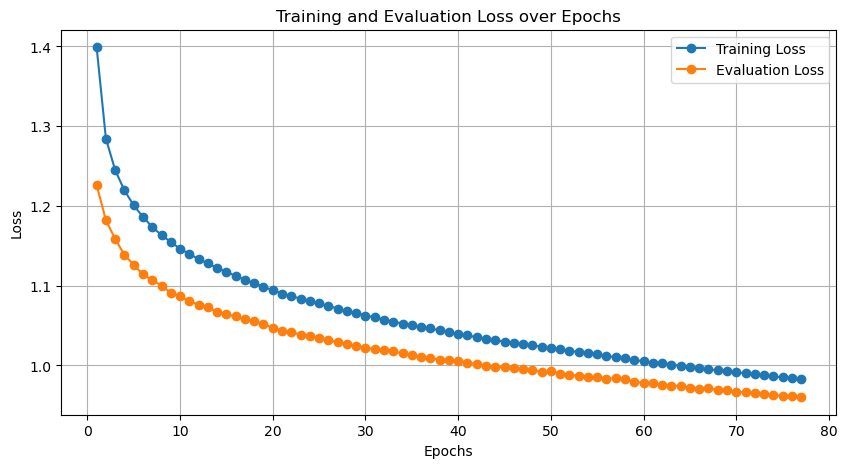

In [14]:
import json
import matplotlib.pyplot as plt

# Charger les données à partir du fichier JSON
with open("finetuning_hugging_whitespace-finetuned-imdb/checkpoint-4408250/trainer_state.json", 'r') as file:
    data = json.load(file)

train_loss = []
eval_loss = []
epoch_train = []
epoch_test=[]

for entry in data['log_history']:
    if 'loss' in entry:
        train_loss.append(entry['loss'])
        epoch_train.append((entry['epoch']))
    elif 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])
        epoch_test.append((entry['epoch']))

plt.figure(figsize=(10, 5))
plt.plot(epoch_train, train_loss, label='Training Loss', marker='o')
plt.plot(epoch_test, eval_loss, label='Evaluation Loss', marker='o')
plt.title('Training and Evaluation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pad_token_id= tokenizer.pad_token_id
sep_token_id = tokenizer.sep_token_id

In [45]:
def evaluate_model_token(model,dataloader):
    model.eval()
    correct_pred=[]
    incorrect_pred=[]

    for batch in dataloader:
        batch = {key: value.to(device) for key, value in batch.items()} 
        with torch.no_grad():
            outputs=model(**batch)
        predictions=torch.argmax(outputs.logits,dim=-1)
        indices_tokens_masked = torch.nonzero(batch["labels"] != -100, as_tuple=False)
        correct_indices=[]
        incorrect_indices=[]
        for id,label in enumerate(batch["labels"][indices_tokens_masked[:, 0], indices_tokens_masked[:, 1]]):
            if label.item() == predictions[indices_tokens_masked[:, 0], indices_tokens_masked[:, 1]][id]:
                correct_indices.append(id)
            else :
                incorrect_indices.append(id)
        correct_pred.extend(batch['labels'][indices_tokens_masked[:, 0], indices_tokens_masked[:, 1]][correct_indices])
        incorrect_pred.extend(batch['labels'][indices_tokens_masked[:, 0], indices_tokens_masked[:, 1]][incorrect_indices])

    return correct_pred,incorrect_pred

In [39]:
hugging_face_correct,hugging_face_incorrect = evaluate_model_token(model_hugging_face,valid_dataloader)

In [44]:
hugging_face_incorrect_unique = list(set(hugging_face_incorrect))
hugging_face_incorrect_unique


['+',
 '6',
 '«',
 '?',
 'J',
 ',',
 'å',
 'y',
 'ë',
 '$',
 'E',
 'k',
 'U',
 'á',
 "'",
 'Y',
 'f',
 'w',
 '>',
 'm',
 'G',
 '_',
 '2',
 '&',
 'O',
 'n',
 'i',
 'ö',
 'ä',
 'I',
 '£',
 ':',
 '-',
 '.',
 'd',
 'D',
 '*',
 'V',
 '[',
 ']',
 'ç',
 'A',
 'Q',
 '!',
 'l',
 'K',
 'é',
 'h',
 'q',
 'à',
 'b',
 'T',
 'P',
 'c',
 'N',
 '8',
 'g',
 'ü',
 '§',
 '%',
 'L',
 'Z',
 '=',
 'r',
 '4',
 'a',
 '"',
 '#',
 '—',
 'ã',
 ';',
 '1',
 'W',
 'S',
 'É',
 'M',
 'H',
 'R',
 ')',
 'j',
 'F',
 'Ö',
 'Ä',
 'z',
 'ø',
 '|',
 'Å',
 '€',
 '(',
 'è',
 'x',
 '»',
 'B',
 's',
 '0',
 'v',
 'Ó',
 't',
 '5',
 '<',
 'ó',
 ' ',
 'X',
 'e',
 'u',
 '9',
 '3',
 'p',
 'o',
 'C',
 '/',
 '7']

In [46]:
hugging_correct,hugging_incorrect=evaluate_model_token(model_hugging_face,valid_dataloader)

In [53]:
base_correct,base_incorrect=evaluate_model_token(model_kb,valid_dataloader)

In [54]:
from collections import Counter
def decoding_text(list):
    counter = Counter(list)

    # Trier les éléments par leur fréquence décroissante
    sorted_numbers = sorted(counter.items(), key=lambda x: x[1], reverse=True)

    # Extraire les chiffres triés
    unique_sorted_numbers = [num for num, _ in sorted_numbers]

    decoded_texts = []
    for tensor in unique_sorted_numbers:
        decoded_text = tokenizer.decode(tensor.item())
        decoded_texts.append(decoded_text)
    return decoded_texts

In [55]:
decoded_base_correct = decoding_text(base_correct)
decoded_hugging_correct = decoding_text(hugging_correct)

In [61]:
print(len(decoded_base_correct)/(len(decoded_base_correct)+len(base_incorrect)))
print(len(decoded_hugging_correct)/(len(decoded_hugging_correct)+len(hugging_incorrect)))

0.5899161482519455
0.7792149671790606


In [59]:
good_tokens = list(set(decoded_hugging_correct)-set(decoded_base_correct))
print(len(good_tokens))
good_tokens

2078


['flät',
 '##oarer',
 'FAST',
 '##tain',
 'köttbullar',
 'Stadens',
 '##omter',
 'gled',
 'Smart',
 'Längd',
 '##vita',
 'lättad',
 'Up',
 'sankt',
 '##smaskin',
 '##etecken',
 'Eget',
 '##stjärnor',
 '##icers',
 '##bero',
 '##IER',
 '##alom',
 '##frusna',
 '##butik',
 'invester',
 'avsiktligt',
 '##ANN',
 'Europat',
 'Måndag',
 'vandringen',
 'that',
 'Örgryte',
 '##ändskt',
 'Alex',
 'nybyggt',
 '##växel',
 '##aton',
 'Burton',
 '##YK',
 '##ugget',
 '##artan',
 'östern',
 'Globen',
 'Mood',
 '##ward',
 'avveck',
 '##ales',
 '##avd',
 '##såsen',
 '##miral',
 'grytan',
 'vänskapen',
 '##harmon',
 '##ssäsongen',
 '##embl',
 'Raf',
 'Stein',
 'avhandlingen',
 'uppn',
 'musikdirektör',
 '##ografier',
 'trampade',
 '##less',
 'Cirk',
 '##igan',
 '##127',
 '##oplan',
 'Teresa',
 '##ipa',
 'skotten',
 'sun',
 'mästar',
 '##sutställningen',
 'Emilia',
 'Österb',
 '##ävlan',
 '##skiv',
 '668',
 'uppen',
 '##merna',
 'gamm',
 '##rukna',
 '##lekar',
 '##gnost',
 '##oning',
 '786',
 '##provinsen'

In [56]:
len(decoded_texts)

3231899

In [ ]:
max_length=128

In [ ]:
def insert_special_masking(batch,i):
    word_ids=batch["word_ids"]
 
    masked_input_id=batch["input_ids"].copy()
    attention_mask=batch["attention_mask"].copy()
 
    labels=[[-100]*max_length]*len(batch["labels"])
    for z in range(len(masked_input_id)):
        if batch["input_ids"][z][i] ==tokenizer.pad_token_id or batch["input_ids"][z][i] ==tokenizer.sep_token_id:
            continue
        
        labels[z][i]=batch["input_ids"][z][i]
        masked_input_id[z][i]=tokenizer.mask_token_id
  
        
        word=tokenizer.decode(batch["input_ids"][z][i])
   
        future_token=[j for j,_ in enumerate(word_ids[z]) if word_ids[z][j]==word_ids[z][i] and j>i]

        for j in future_token:
            labels[z][j]=batch["input_ids"][z][j]
    
            masked_input_id[z][j]=tokenizer.mask_token_id
           

        masked_input_id[z]=np.array(masked_input_id[z])
        attention_mask[z]=np.array(attention_mask[z])
        labels[z]=np.array(labels[z])
   
    output_dict = {"input_ids": masked_input_id, "attention_mask": attention_mask, "labels": labels}
    
    return {k: v for k, v in output_dict.items()}

In [ ]:
def insert_special_masking_bis(batch, i):
    word_ids = batch["word_ids"]
    masked_input_id = batch["input_ids"].copy()
    attention_mask = batch["attention_mask"].copy()
    
    labels = np.full_like(masked_input_id, -100)
    
    for z, seq in enumerate(masked_input_id):
        if seq[i] == tokenizer.pad_token_id or seq[i] == tokenizer.sep_token_id:
            continue
        
        labels[z, i] = seq[i]
        masked_input_id[z][i] = tokenizer.mask_token_id
        future_token = [j for j, _ in enumerate(word_ids[z]) if word_ids[z][j] == word_ids[z][i] and j > i]
        
        for j in future_token:
            labels[z][j] = batch["input_ids"][z][j]
            masked_input_id[z][j] = tokenizer.mask_token_id
    
    return {
        "input_ids": masked_input_id,
        "attention_mask": attention_mask,
        "labels": labels
    }

In [ ]:
pll = 0
batch_size=64
for i in  range(max_length):
    print(i)
    losses=[]
    eval_dataset_log = lm_datasets["test"].map(
        lambda examples: insert_special_masking_bis(examples,i),
        batched=True,
        remove_columns= lm_datasets["test"].column_names
    )
    print("daatset")
    eval_dataloader = preprocessing.create_dataloader(eval_dataset_log,batch_size,default_data_collator)
    print("dataloader")
    for step, batch in enumerate(eval_dataloader):
        batch={key: value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            output=model_hugging_face(**batch)
        print("output")
        loss=output.loss
        losses.append(loss.repeat(eval_dataloader.batch_size))
        print("loss")
        break
    losses = torch.cat(losses)
    print("loss")
    #losses = losses[: len(eval_dataloader.dataset)]
    pll += torch.mean(losses)


pll /=max_length
pll

In [ ]:
evaluation_task(model_kb,eval_dataloader)

In [ ]:
regression_year("finetuning_hugging_whitespace-finetuned-imdb/checkpoint-801500")

In [ ]:
def encode(df, tokenizer):
    # Tokenize all of the sentences and map the tokens to their word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for ix, row in df.iterrows():
        encoded_dict = tokenizer.encode_plus(
            row['content'],
            add_special_tokens=True,
            max_length=512,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    print(df["tag"])
    labels = torch.tensor(df['tag'].tolist())

    return input_ids, attention_masks, labels

In [ ]:
import pandas as pd
df = pd.read_csv("swerick_subsetdata_date_test.csv")
df = df.sample(frac=1, random_state=123).reset_index(drop=True)

# Create binary label where seg = 1
df = df[df["content"].notnull()]
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

input_ids, attention_masks, labels = encode(df, tokenizer)

In [ ]:
labels

In [ ]:


# Define your training arguments
training_args = TrainingArguments(
    output_dir=f"{model_long.config.name_or_path}-imdb",
    per_device_eval_batch_size=64,
    # Add other training arguments as needed
    logging_steps=892,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    no_cuda=True
)
print(training_args.device)
# Create the Trainer object
trainer = Trainer(
    model=model_long,
    args=training_args,
    eval_dataset=eval_dataset
)

result = trainer.evaluate()

In [ ]:
result


In [ ]:
math.exp(result['eval_loss'])